In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'GLOBAL', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [3]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('./SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[2] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = (float(row[1]) + float(row[4]))/2.0
                if temp_value != 0:
                    unrealize = (temp - temp_value)/ temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [4]:
stock_datas = [ load_stock_data(x, 2007, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

for index, element in enumerate(stock_datas):
    if len(element) < min_count:
        min_count = len(element)

min_count

2043

In [8]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(64, (7, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
        else:
            model.add(Conv2D(32, (3, 1)))
            
        model.add(Activation('tanh'))
        model.add(MaxPooling2D(pool_size = (2, 1), data_format= "channels_last"))
        i += 1
        
    i = 0
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('tanh'))
        i += 1
    
    return model

In [9]:
size = 9
models = [create_model(int(_/3), _%3) for _ in range(size)]
# (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ... (2, 5)
# first for conv, second for fully connected

In [10]:
lr = 0.95
decay = 1e-6

In [11]:
optimizer = SGD(lr=lr, decay=decay)
for model in models:
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae'])

In [12]:
rounds = min_count - 30
train_index = int(rounds * 0.85)
validate_index = train_index + int(rounds * 0.05)

In [13]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: rounds].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(1711, 37, 30, 1) (100, 37, 30, 1) (202, 37, 30, 1)


In [14]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1711, 37) (100, 37) (202, 37)


In [15]:
epochs = 30

for (index, model) in enumerate(models):
    print(index)
    model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = 1, verbose= 1)
    

0
Train on 1711 samples, validate on 100 samples
Epoch 1/30
1711/1711 [==============================] - 44s 26ms/step - loss: 8.5128e-04 - acc: 0.0409 - mean_absolute_error: 0.0159 - val_loss: 1.9414e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0105
Epoch 2/30
1711/1711 [==============================] - 14s 8ms/step - loss: 7.6486e-04 - acc: 0.0473 - mean_absolute_error: 0.0152 - val_loss: 1.6181e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0095
Epoch 3/30
1711/1711 [==============================] - 15s 9ms/step - loss: 7.2505e-04 - acc: 0.0561 - mean_absolute_error: 0.0148 - val_loss: 1.7863e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0099
Epoch 4/30
1711/1711 [==============================] - 15s 9ms/step - loss: 6.9100e-04 - acc: 0.0725 - mean_absolute_error: 0.0145 - val_loss: 1.6502e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0097
Epoch 5/30
1711/1711 [==============================] - 14s 8ms/step - loss: 6.6489e-04 - acc: 0.0807 - mean_absolute_erro

1711/1711 [==============================] - 54s 32ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 11/30
1711/1711 [==============================] - 54s 32ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 12/30
1711/1711 [==============================] - 54s 32ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 13/30
1711/1711 [==============================] - 54s 32ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 14/30
1711/1711 [==============================] - 54s 32ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 15/30
1711/1711 [==============================] - 54s 32ms/s

1711/1711 [==============================] - 53s 31ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 24/30
1711/1711 [==============================] - 53s 31ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 25/30
1711/1711 [==============================] - 54s 31ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 26/30
1711/1711 [==============================] - 53s 31ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 27/30
1711/1711 [==============================] - 53s 31ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 28/30
1711/1711 [==============================] - 53s 31ms/s

Epoch 3/30
1711/1711 [==============================] - 18s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 4/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 5/30
1711/1711 [==============================] - 18s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 6/30
1711/1711 [==============================] - 18s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 7/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 8/30
1711/1711 [==============================] - 19s 

1711/1711 [==============================] - 20s 12ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 17/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 18/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 19/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 20/30
1711/1711 [==============================] - 19s 11ms/step - loss: nan - acc: 0.0129 - mean_absolute_error: nan - val_loss: nan - val_acc: 0.0300 - val_mean_absolute_error: nan
Epoch 21/30
1711/1711 [==============================] - 20s 11ms/s

Epoch 27/30
1711/1711 [==============================] - 10s 6ms/step - loss: 6.8615e-04 - acc: 0.0544 - mean_absolute_error: 0.0149 - val_loss: 1.6363e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0094
Epoch 28/30
1711/1711 [==============================] - 10s 6ms/step - loss: 6.8769e-04 - acc: 0.0508 - mean_absolute_error: 0.0148 - val_loss: 1.5561e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0092
Epoch 29/30
1711/1711 [==============================] - 10s 6ms/step - loss: 6.8640e-04 - acc: 0.0561 - mean_absolute_error: 0.0148 - val_loss: 1.6658e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0095
Epoch 30/30
1711/1711 [==============================] - 10s 6ms/step - loss: 6.8349e-04 - acc: 0.0503 - mean_absolute_error: 0.0148 - val_loss: 1.5350e-04 - val_acc: 0.0300 - val_mean_absolute_error: 0.0092
7
Train on 1711 samples, validate on 100 samples
Epoch 1/30
1711/1711 [==============================] - 14s 8ms/step - loss: 0.0010 - acc: 0.0327 - mean_absolute_error

1711/1711 [==============================] - 13s 8ms/step - loss: 8.3082e-04 - acc: 0.0292 - mean_absolute_error: 0.0160 - val_loss: 2.1379e-04 - val_acc: 0.0100 - val_mean_absolute_error: 0.0111
Epoch 7/30
1711/1711 [==============================] - 14s 8ms/step - loss: 8.1752e-04 - acc: 0.0450 - mean_absolute_error: 0.0160 - val_loss: 1.8813e-04 - val_acc: 0.0200 - val_mean_absolute_error: 0.0104
Epoch 8/30
1711/1711 [==============================] - 14s 8ms/step - loss: 8.0529e-04 - acc: 0.0362 - mean_absolute_error: 0.0161 - val_loss: 1.7120e-04 - val_acc: 0.0600 - val_mean_absolute_error: 0.0097
Epoch 9/30
1711/1711 [==============================] - 14s 8ms/step - loss: 7.9688e-04 - acc: 0.0544 - mean_absolute_error: 0.0159 - val_loss: 1.6750e-04 - val_acc: 0.0400 - val_mean_absolute_error: 0.0096
Epoch 10/30
1711/1711 [==============================] - 13s 8ms/step - loss: 7.9078e-04 - acc: 0.0427 - mean_absolute_error: 0.0160 - val_loss: 1.8344e-04 - val_acc: 0.0300 - val_mea

In [ ]:
for model in models:

In [16]:
predicts = [[] for i in range(size)]
for i in range(size):
    test_data = x_test.copy()
    for (index, element) in enumerate(y_test):
        predict = models[i].predict(test_data, verbose = 0)
        predicts[i].append(predict[0])
        test_data = findNewXTest(test_data, predict[0])

In [17]:
predicts = [np.asarray(predict).astype('float32') for predict in predicts]

In [18]:
def plot_graph(array1, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


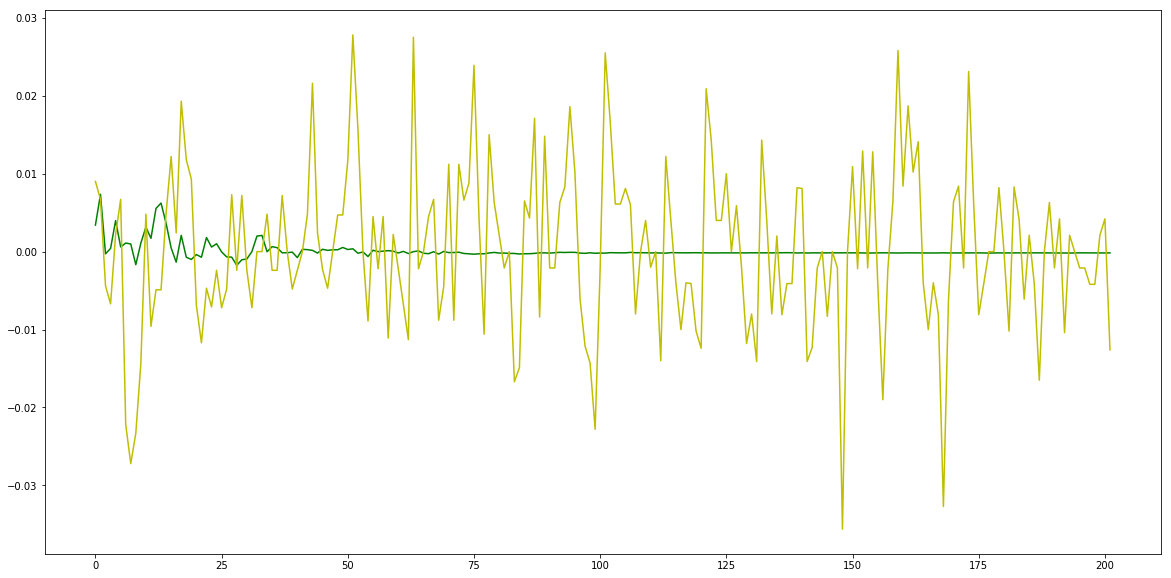

AOT


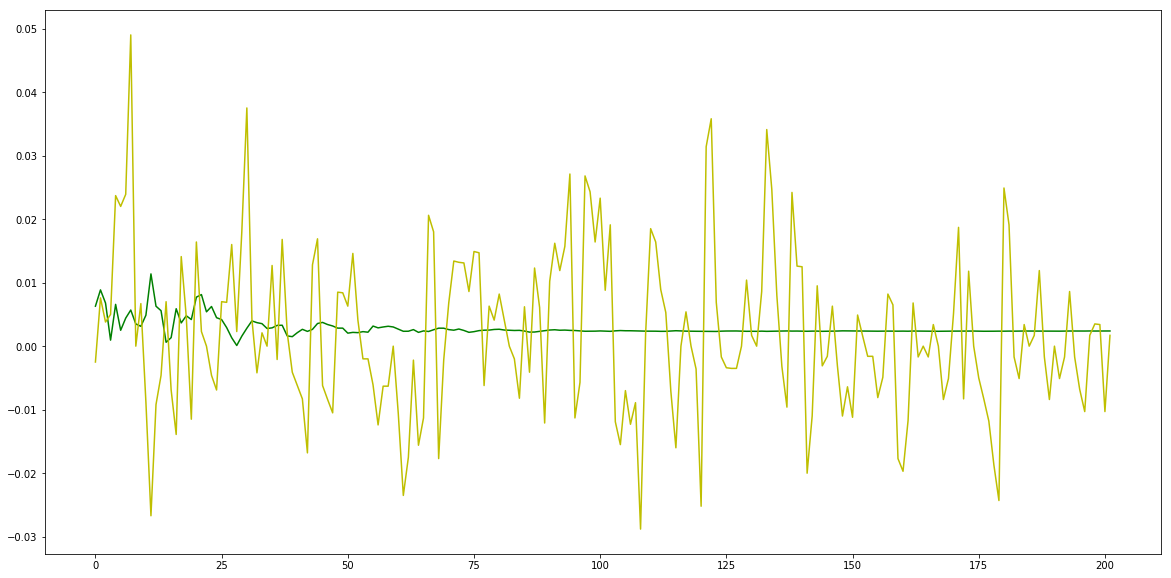

BANPU


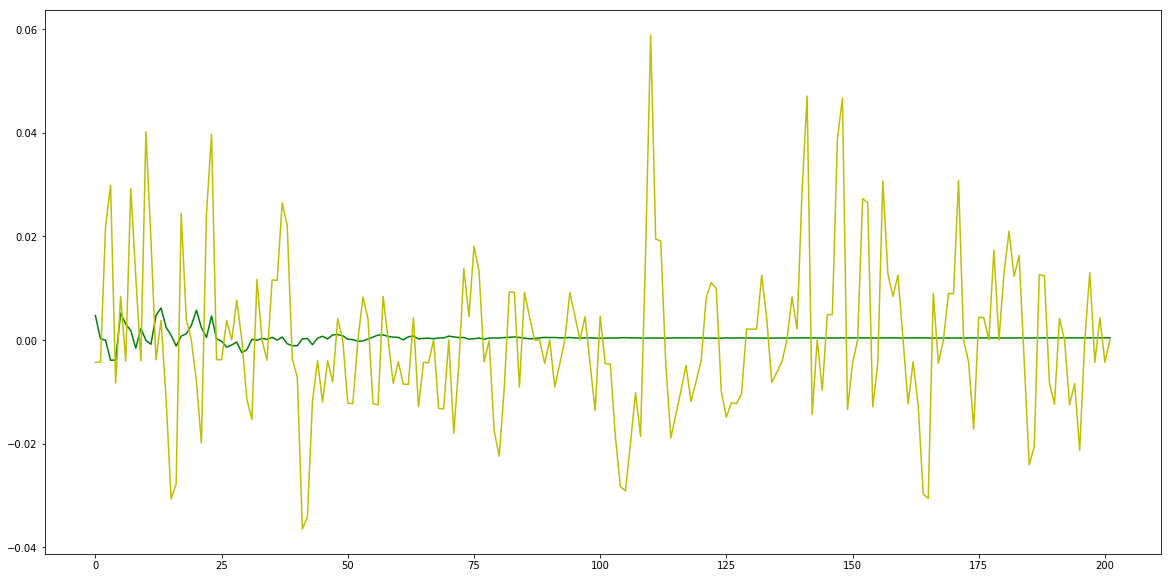

BBL


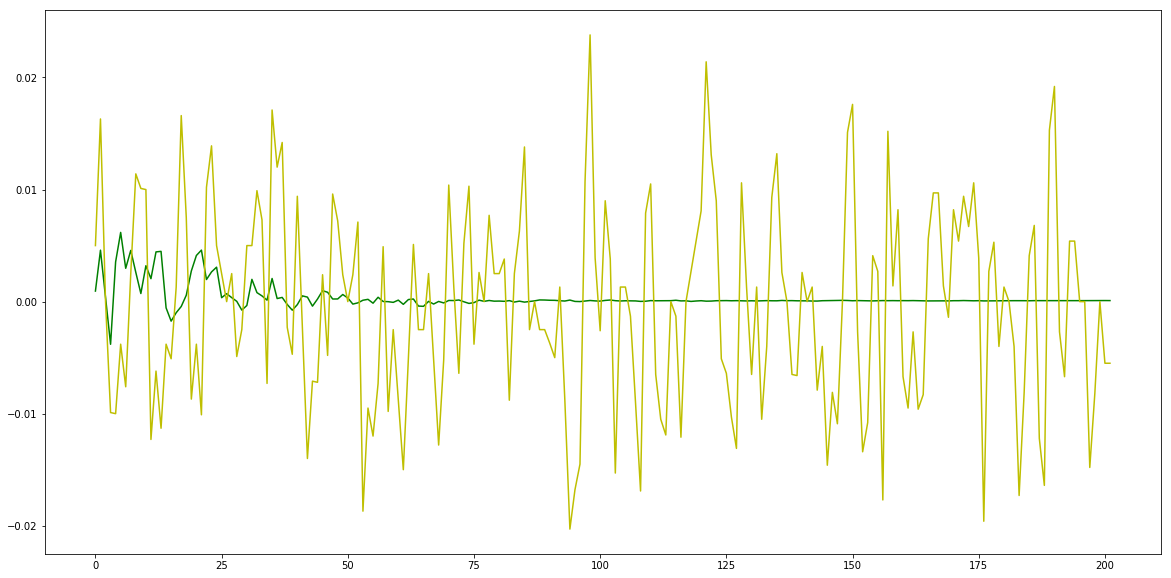

BCP


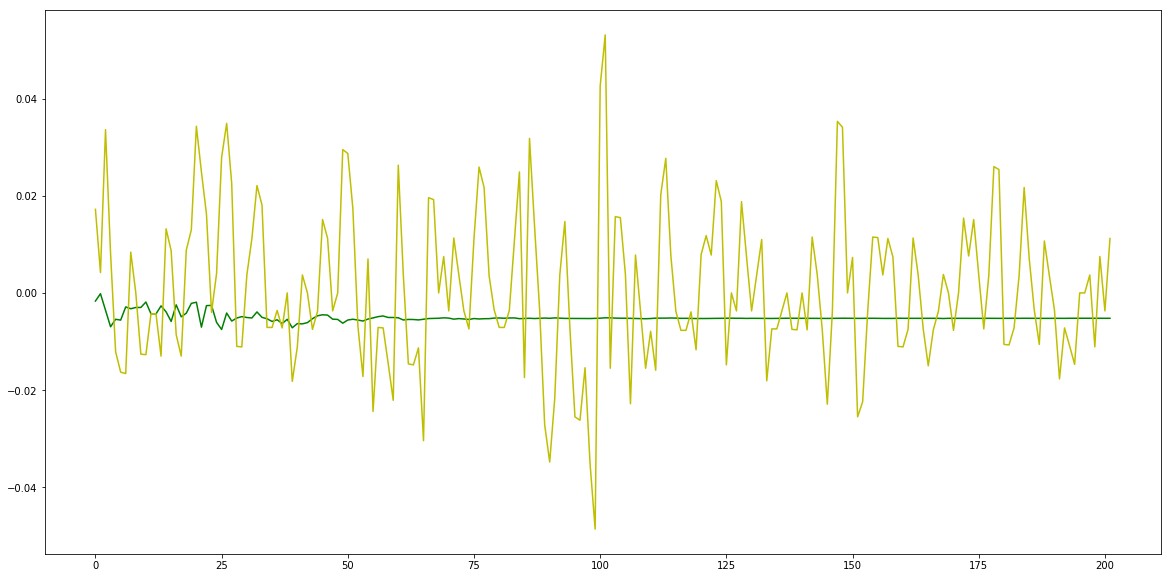

BDMS


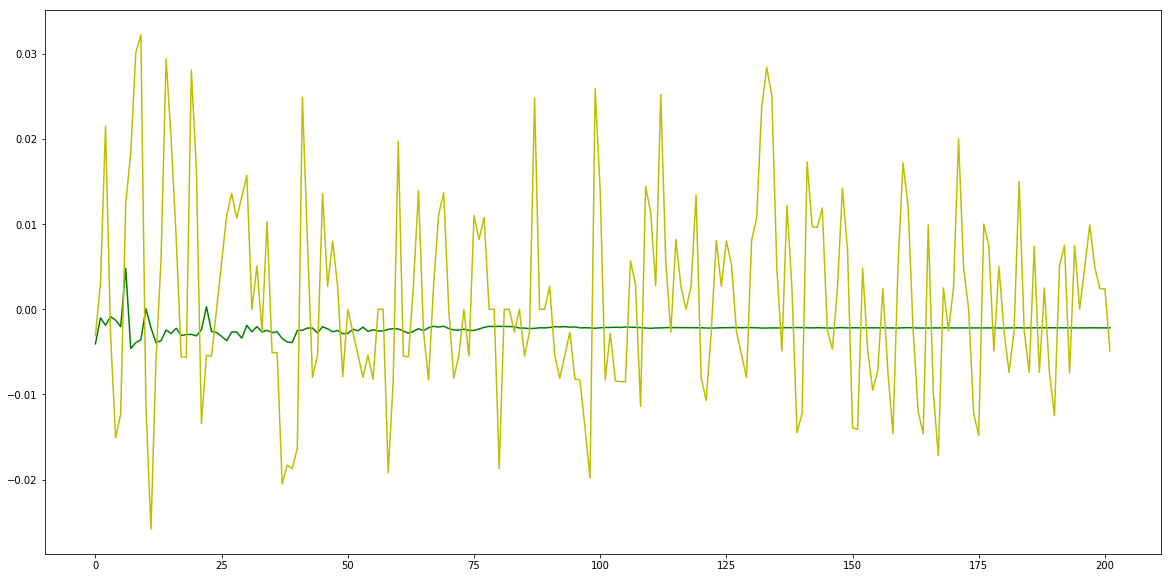

BEM


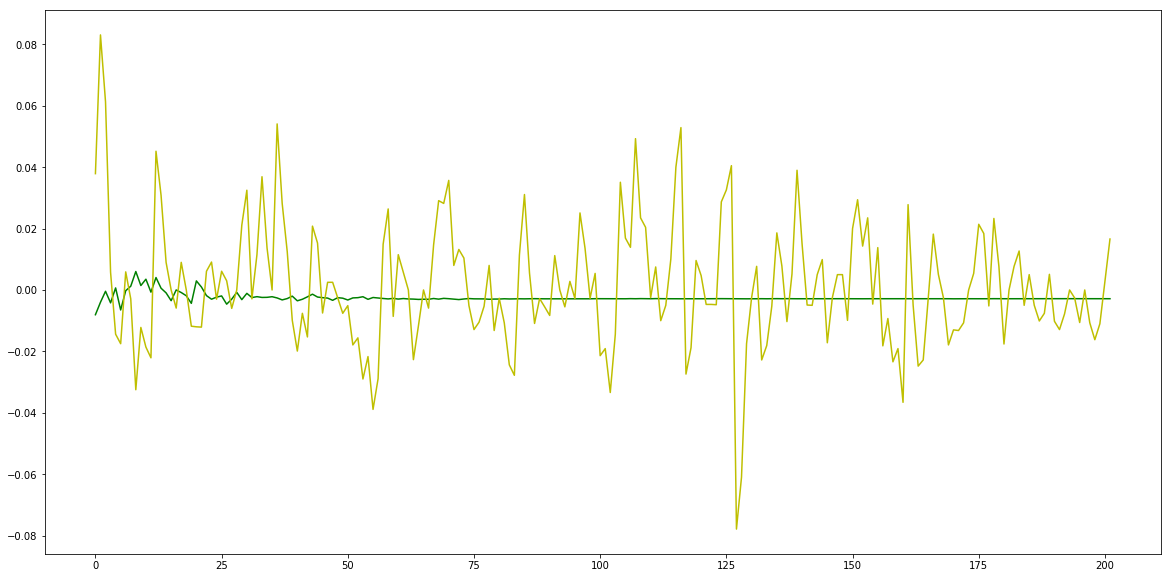

BH


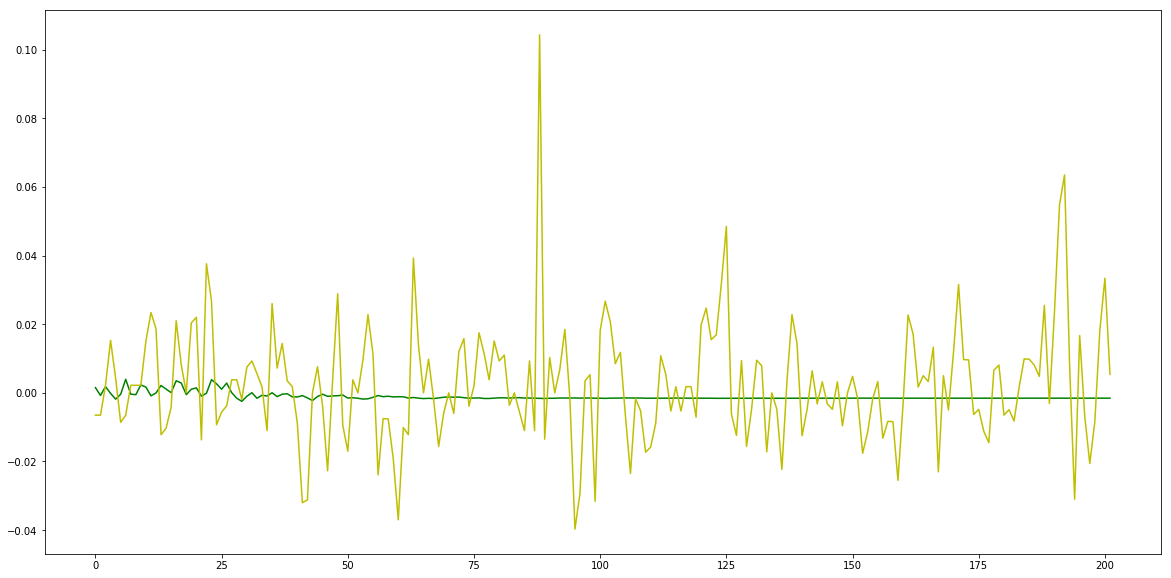

BJC


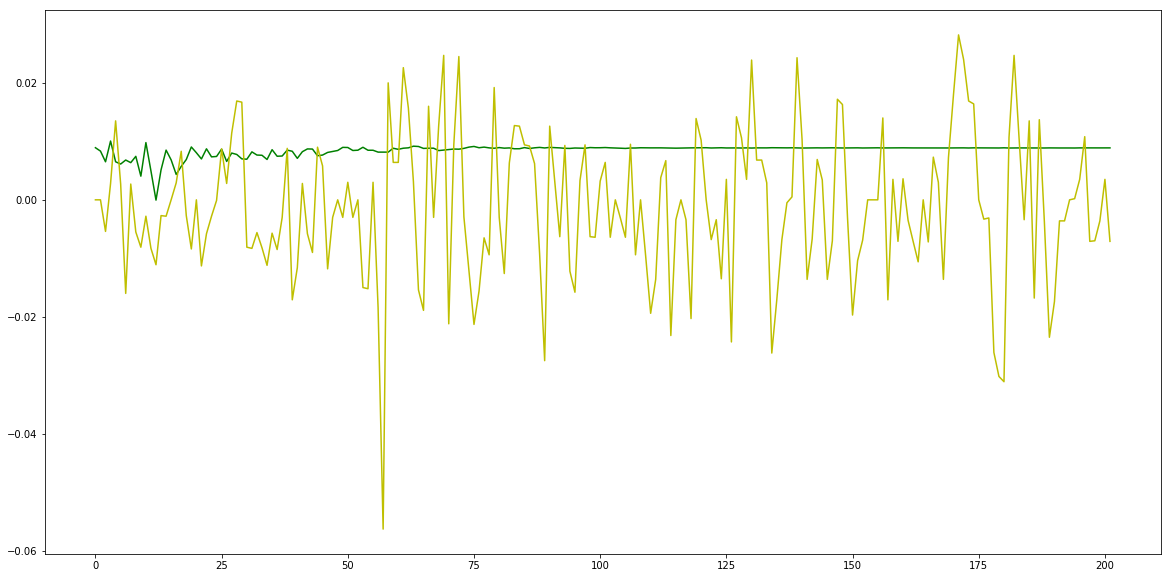

BTS


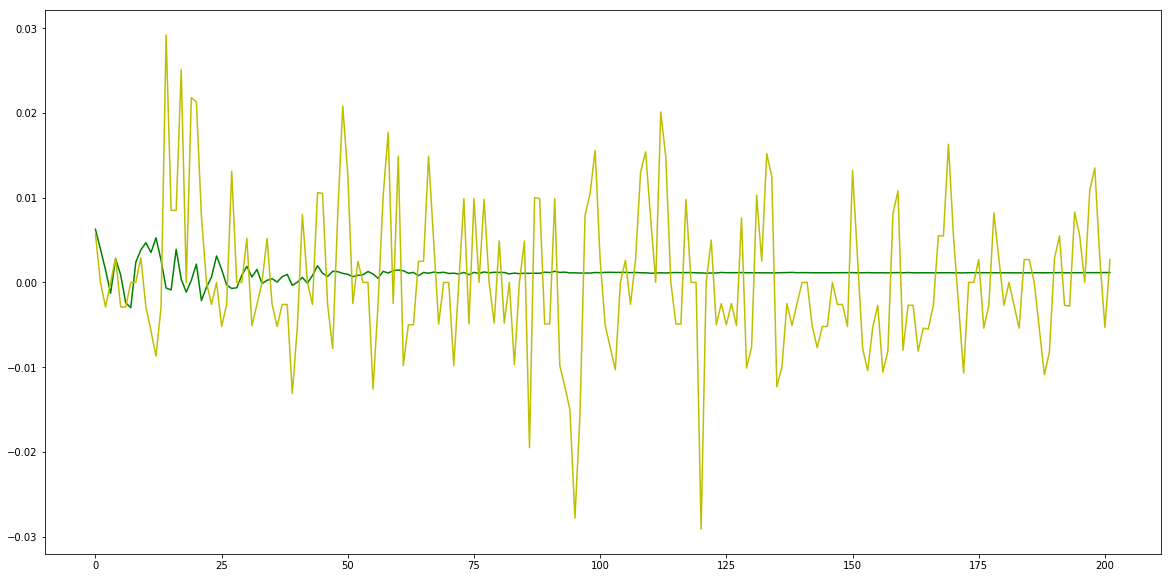

CENTEL


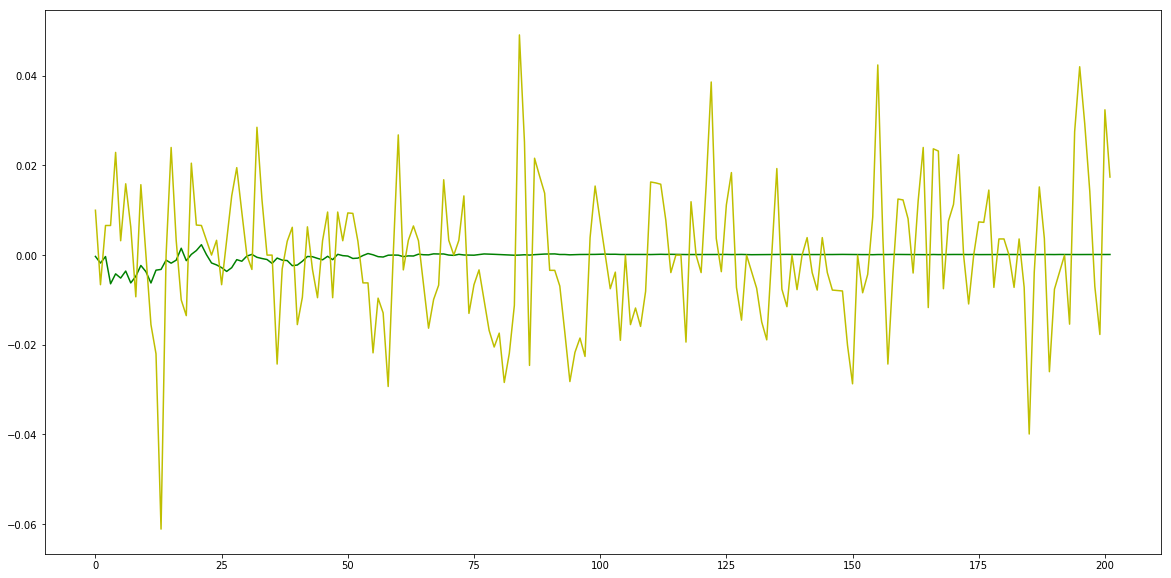

CPALL


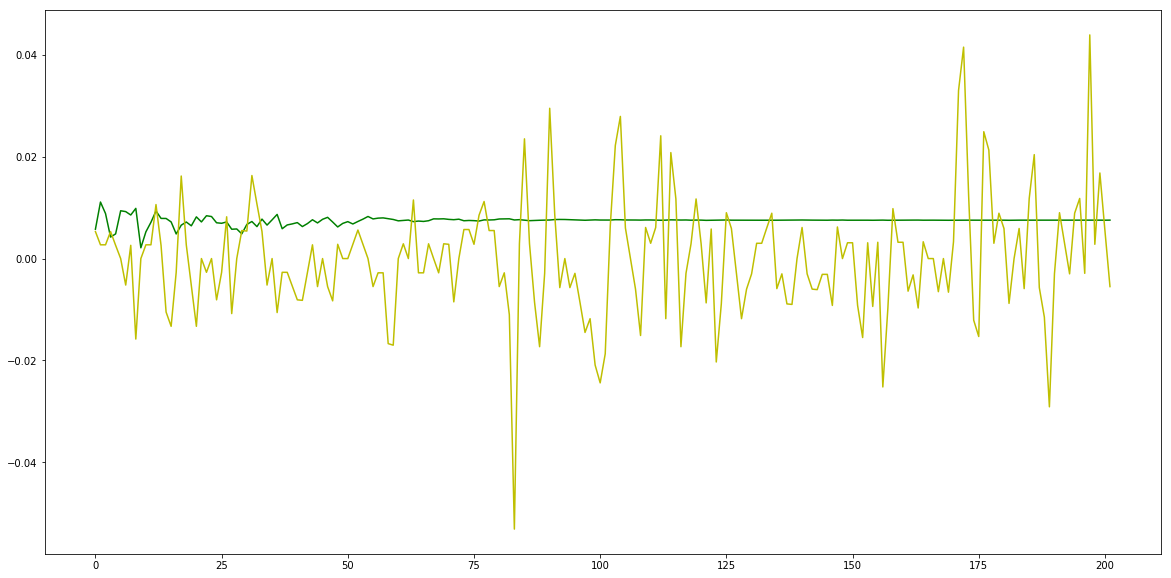

CPF


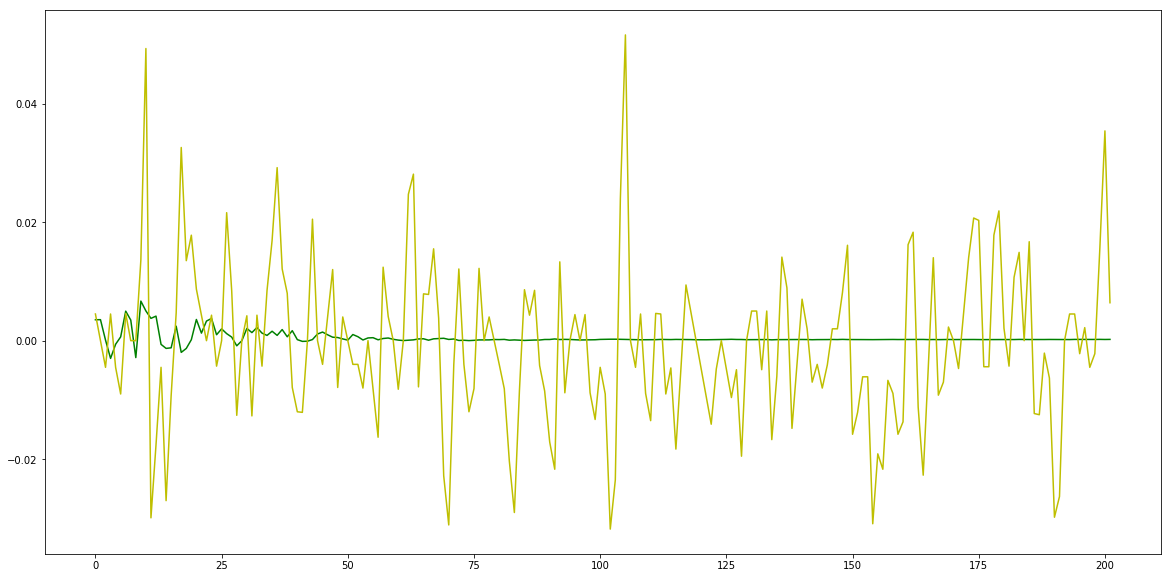

CPN


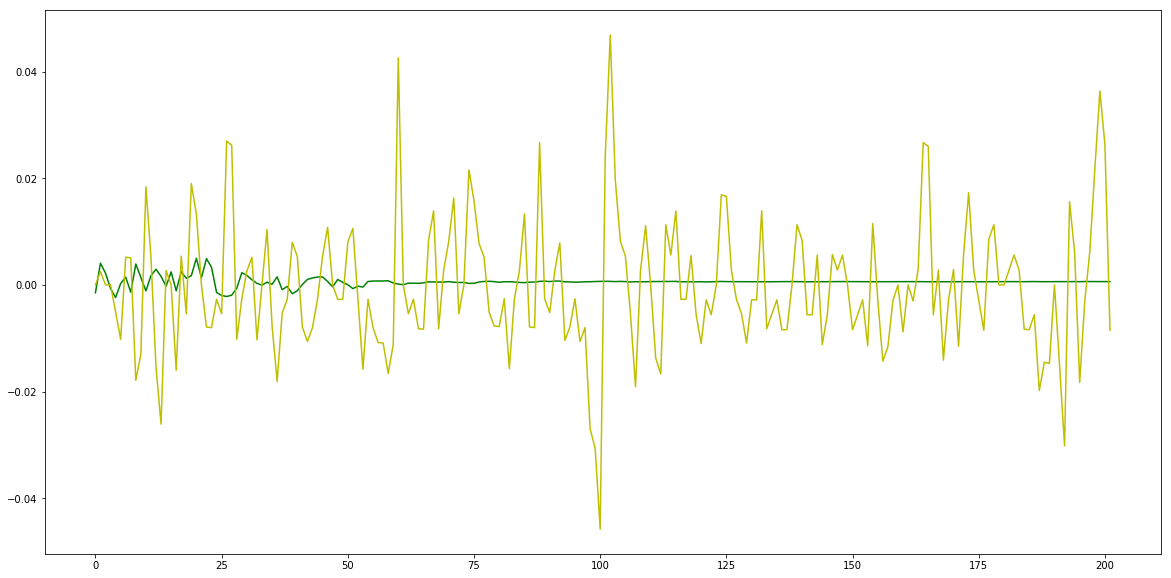

DTAC


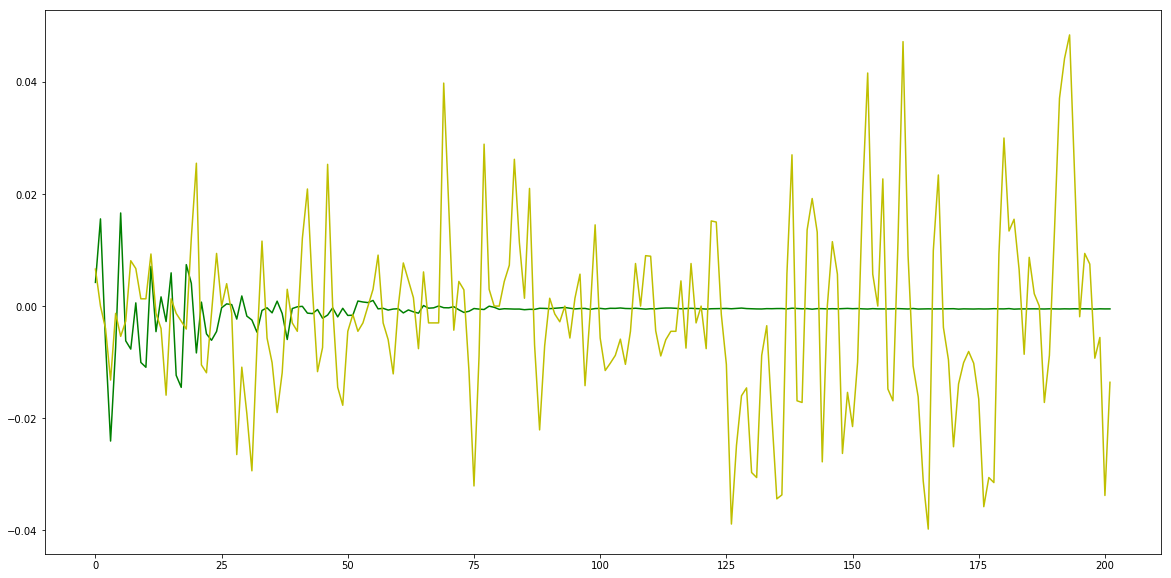

EGCO


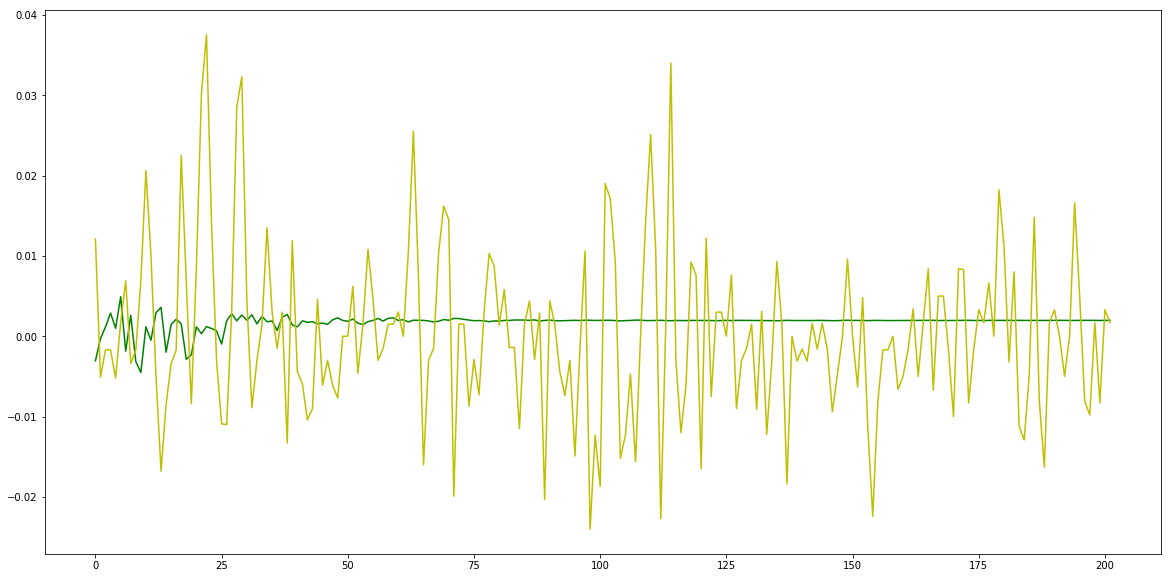

GLOBAL


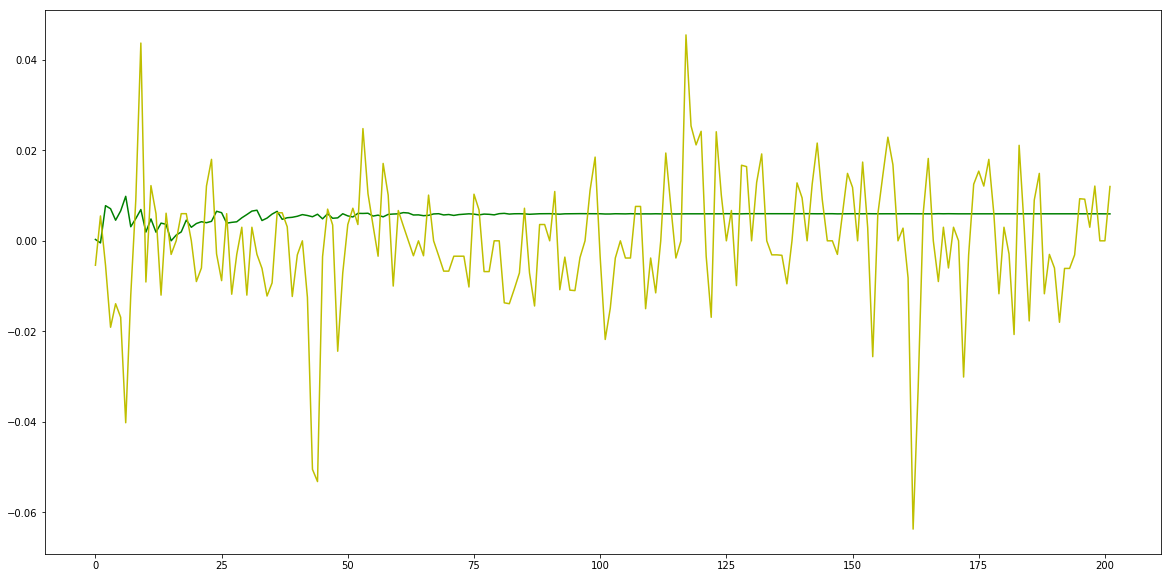

HMPRO


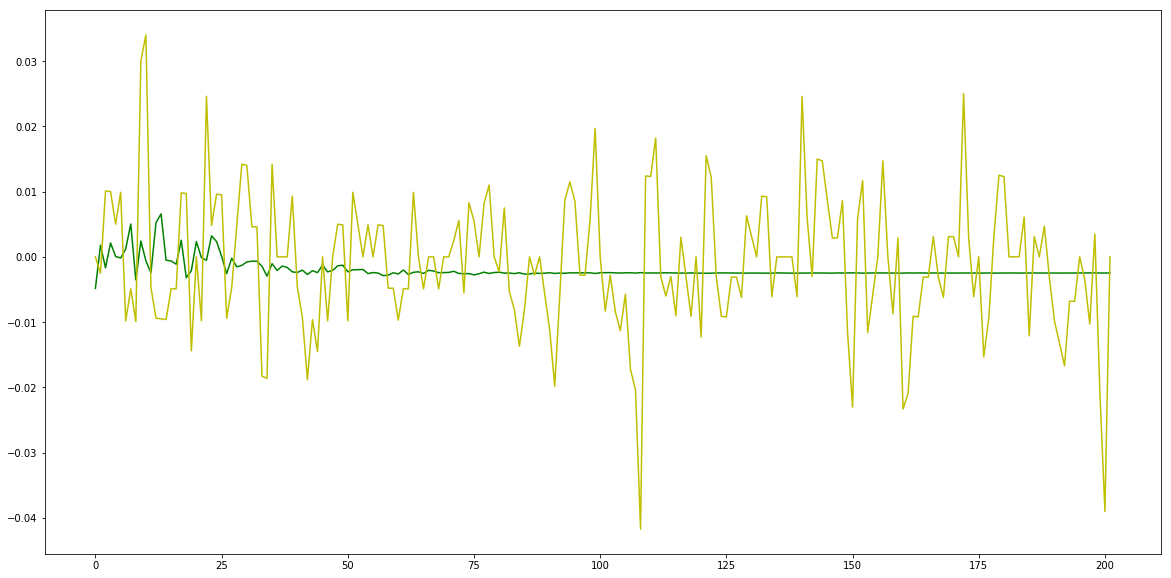

INTUCH


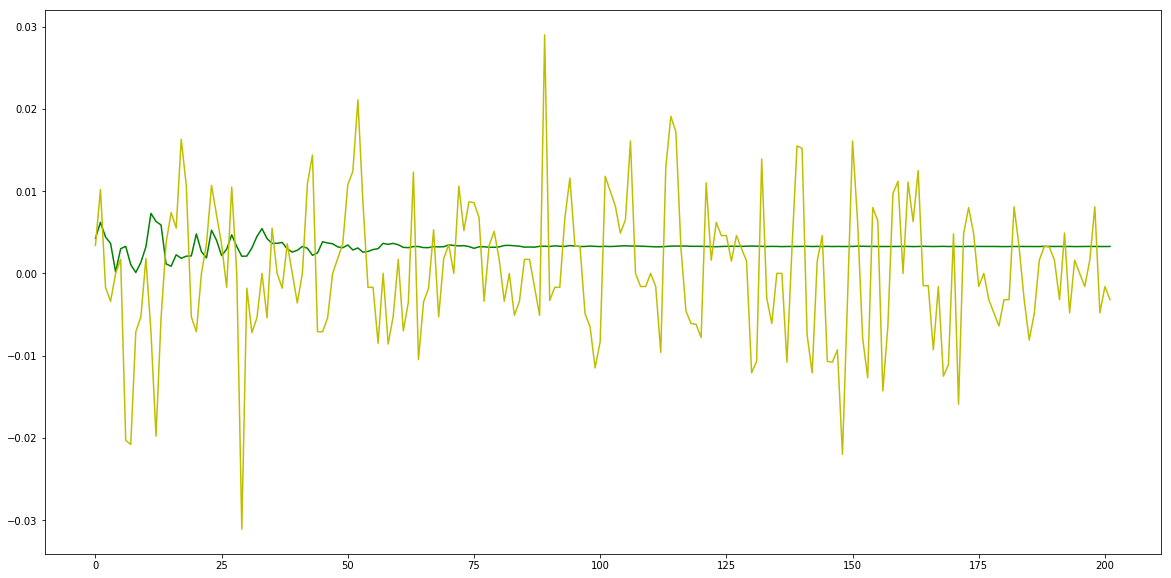

IRPC


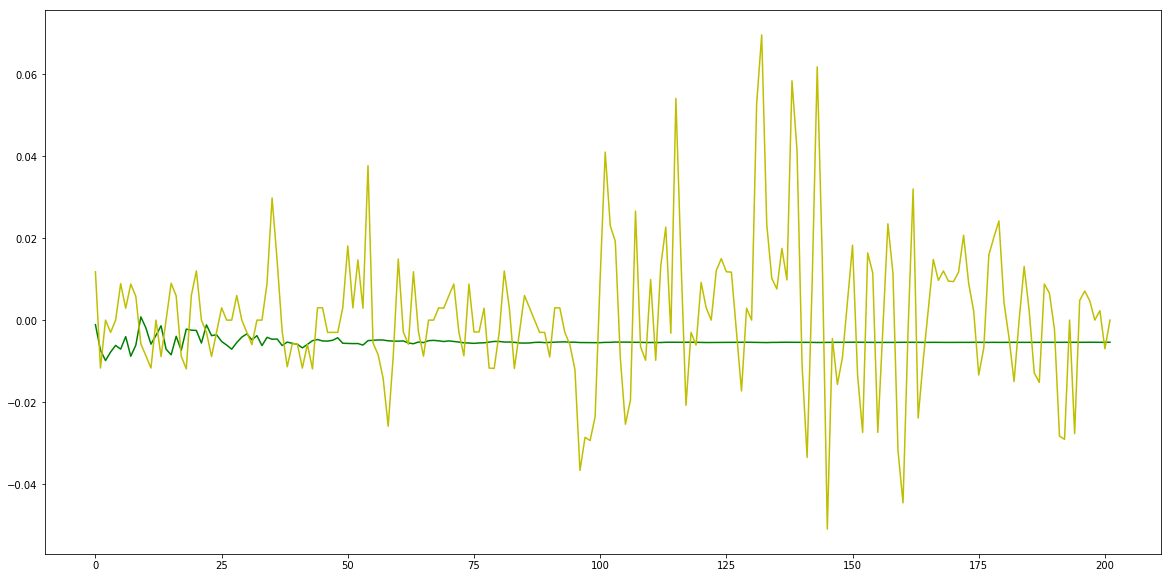

KBANK


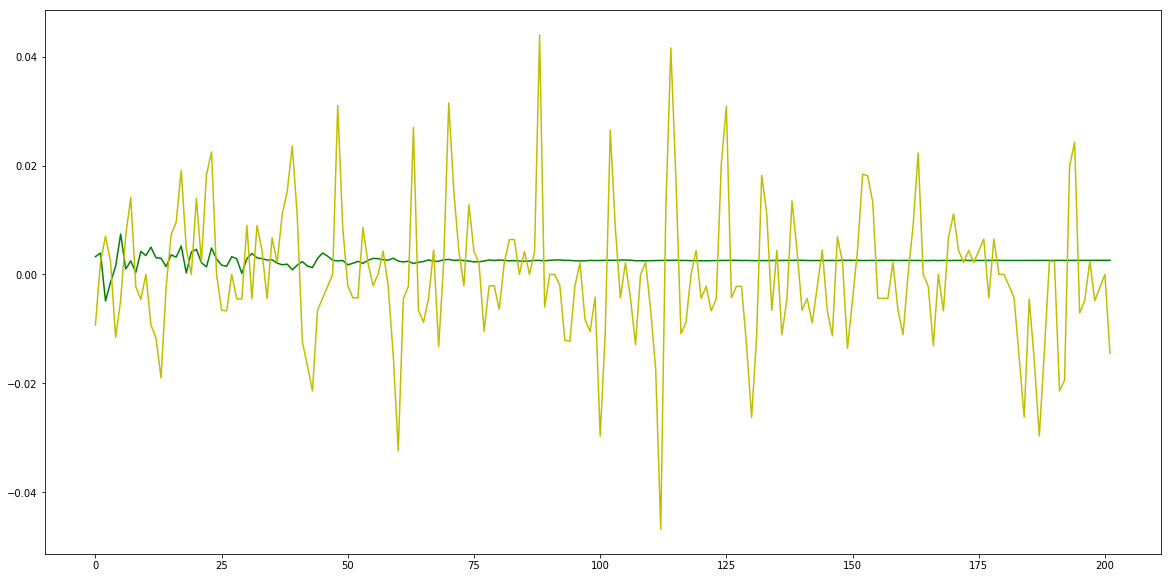

KCE


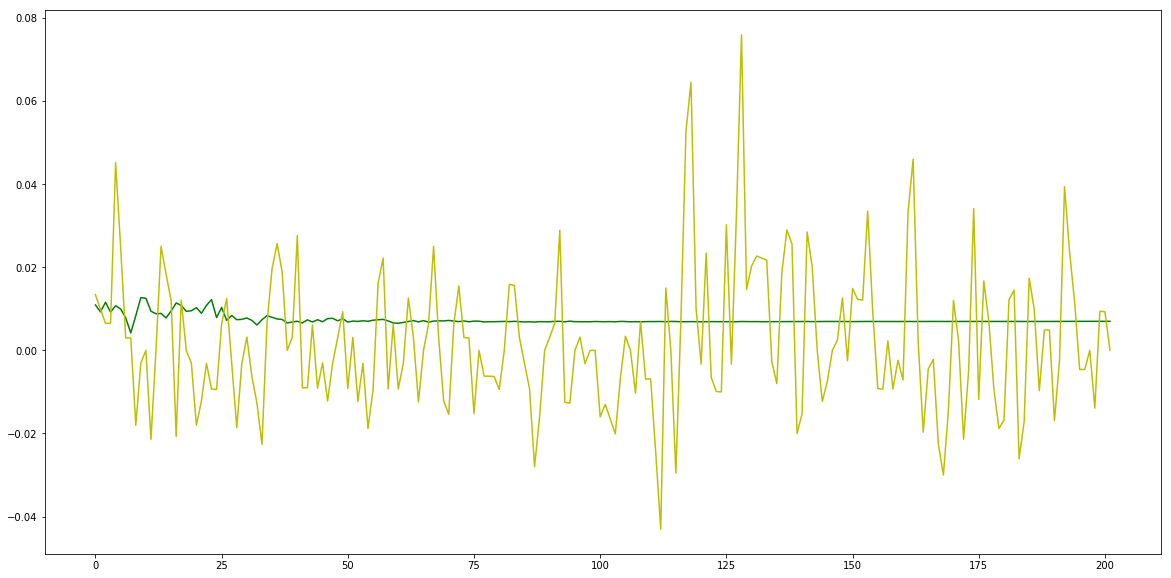

KKP


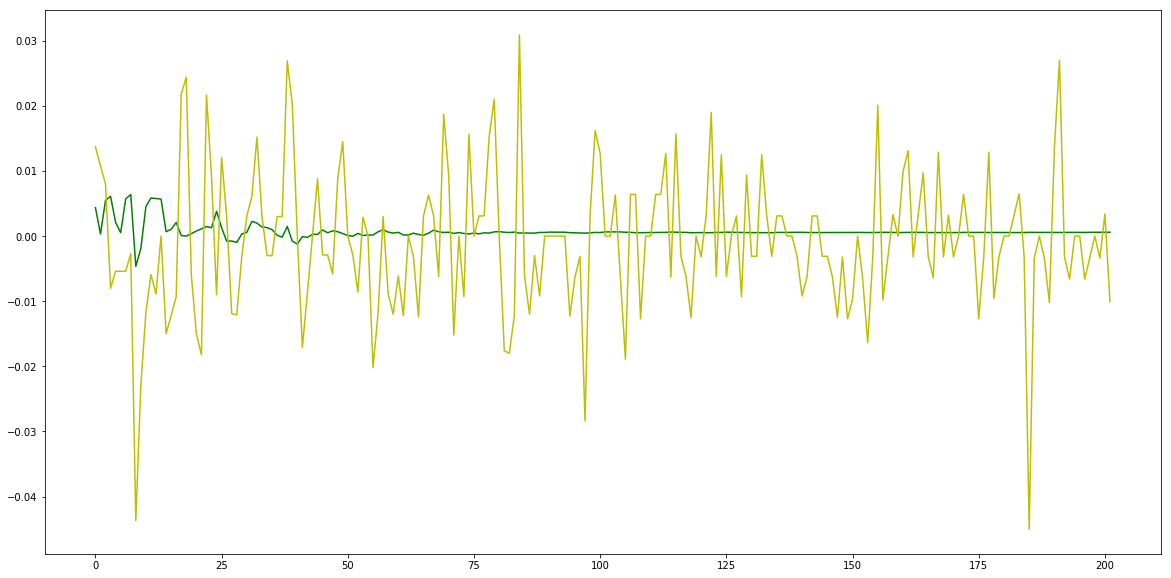

KTB


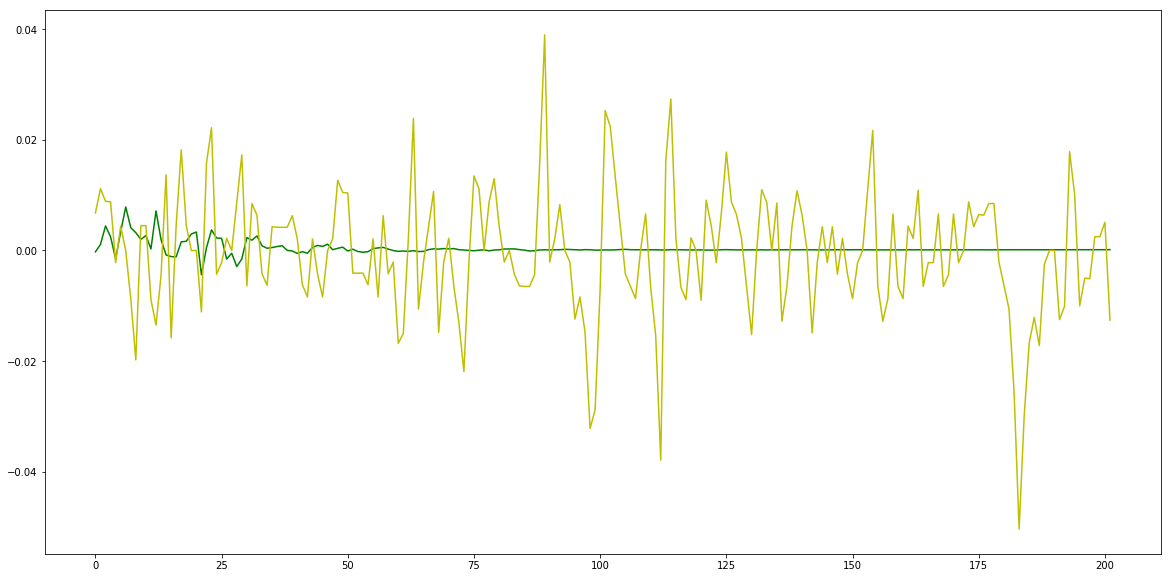

LH


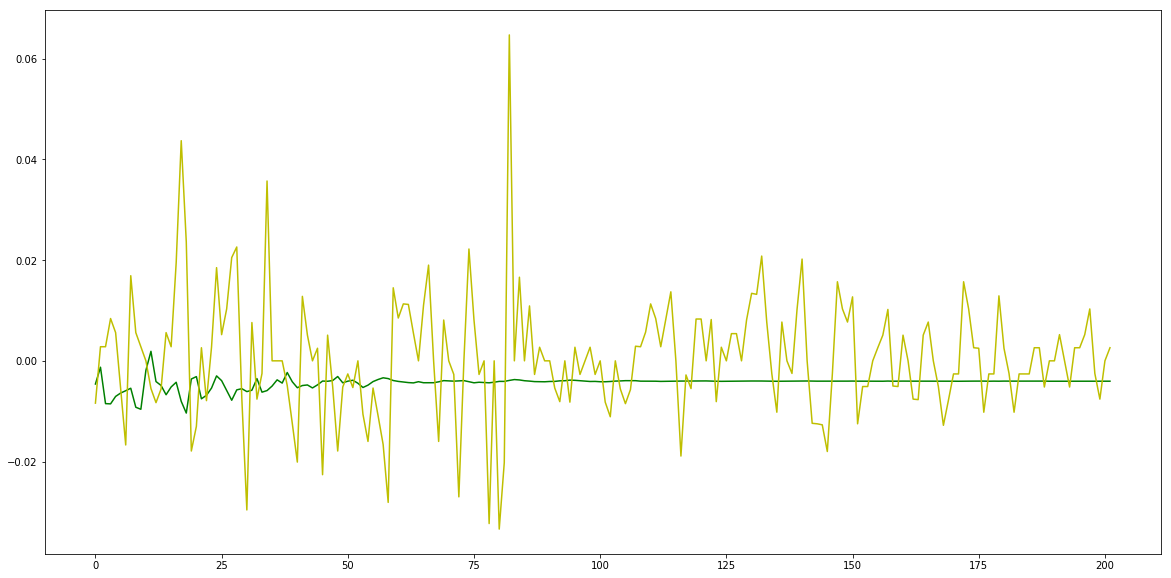

MINT


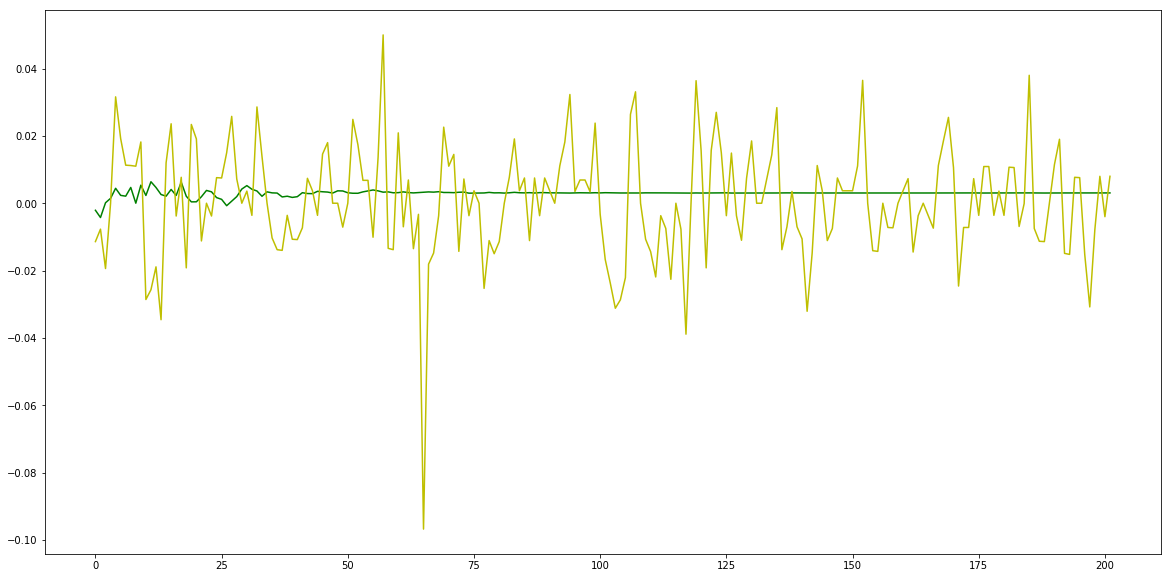

PTT


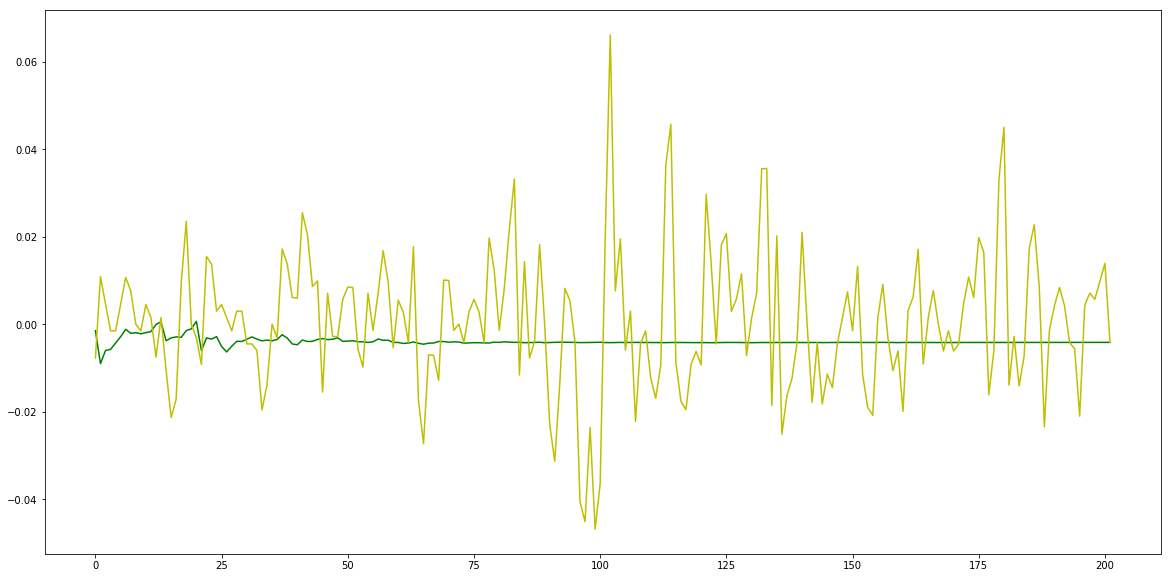

PTTEP


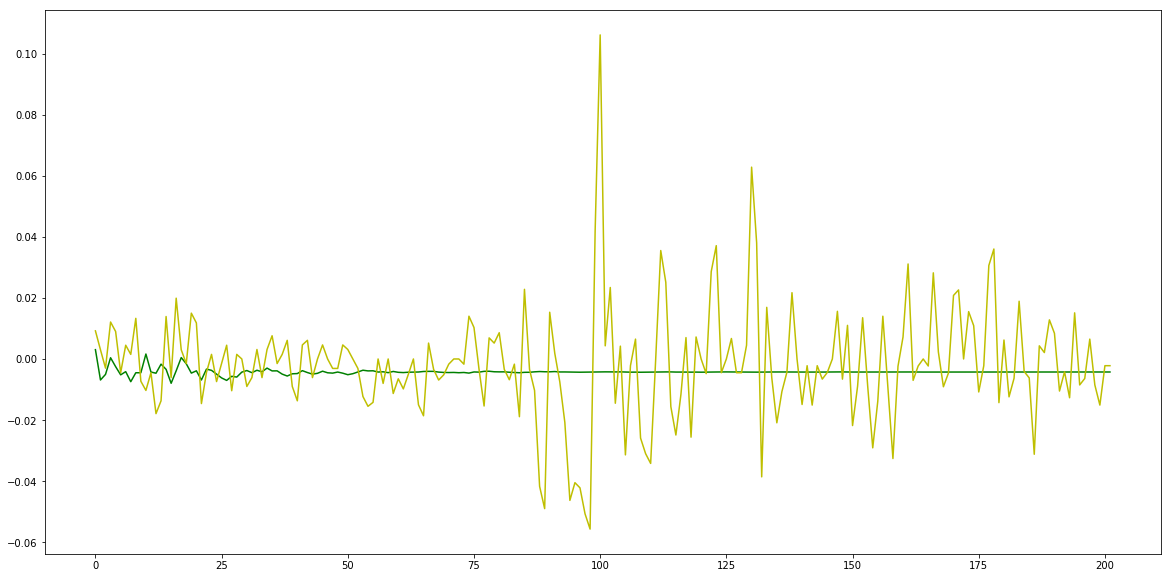

ROBINS


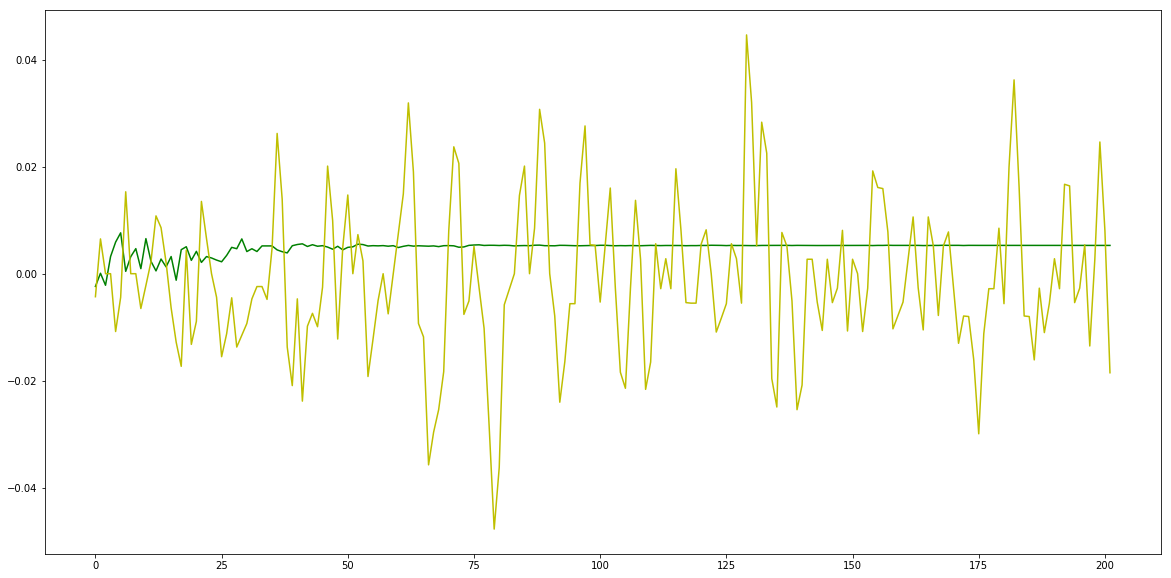

SCB


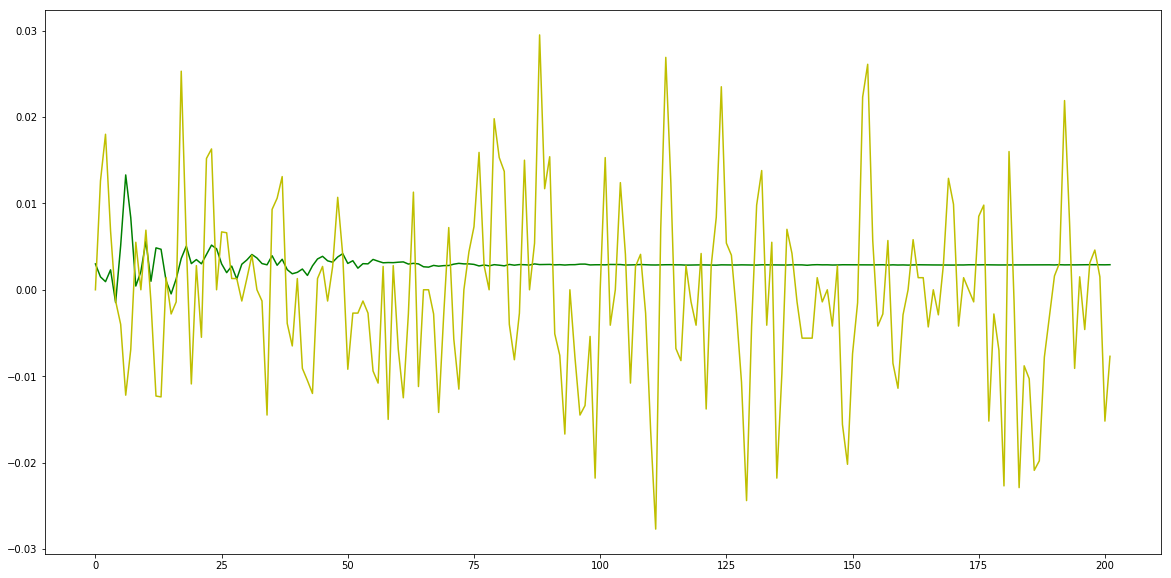

SCC


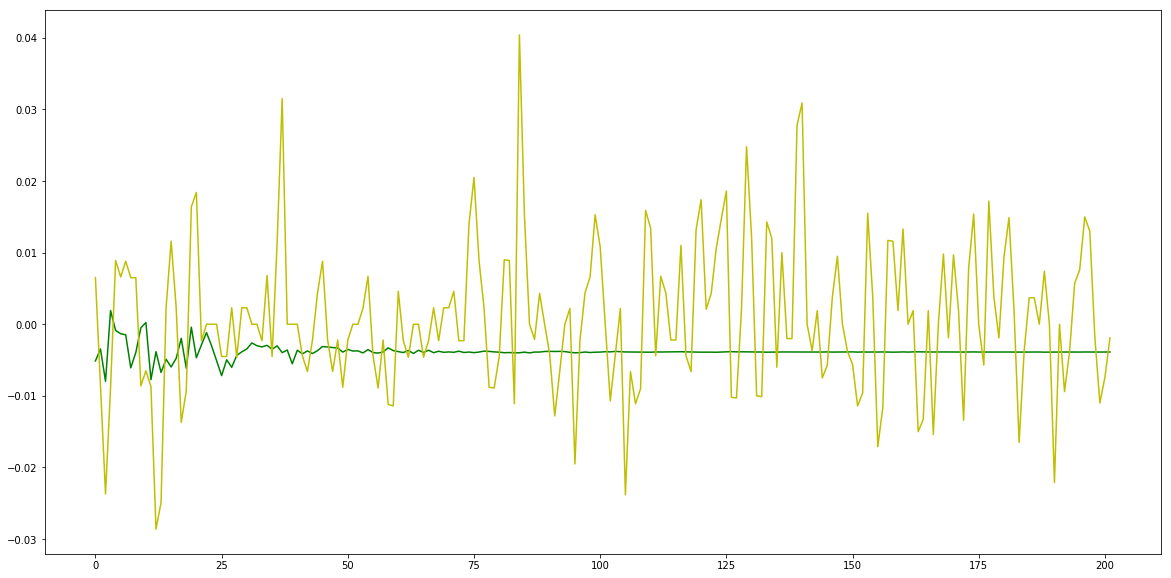

TCAP


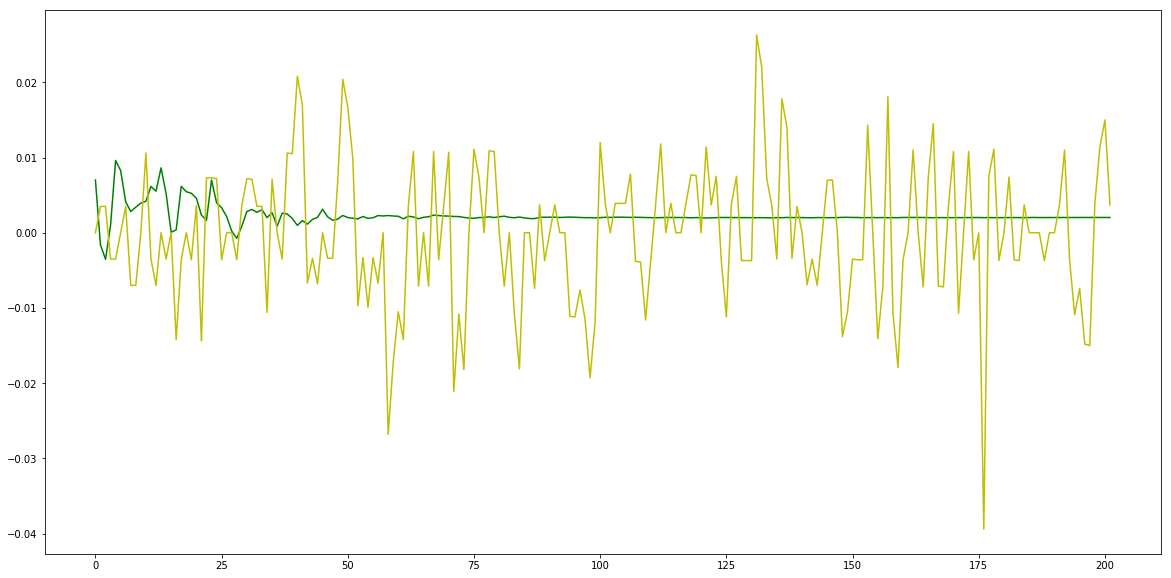

TISCO


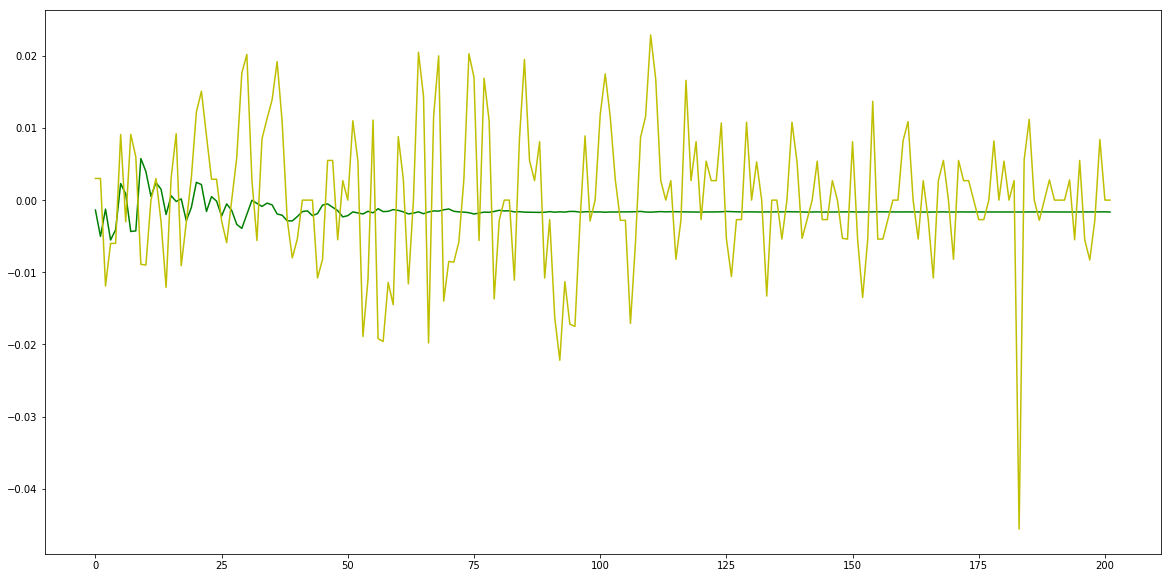

TMB


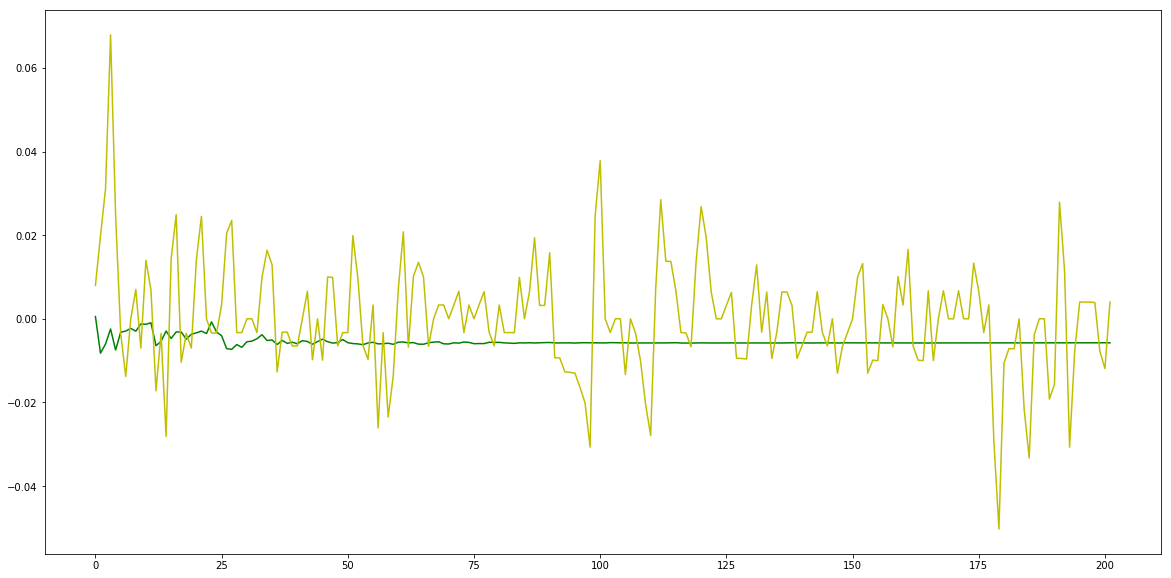

TOP


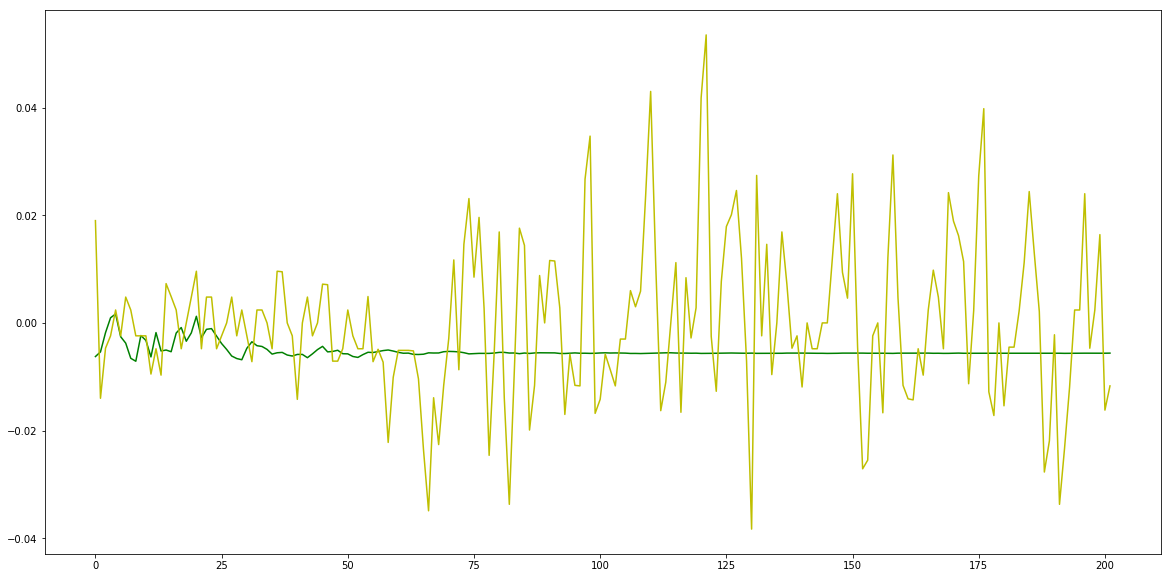

TRUE


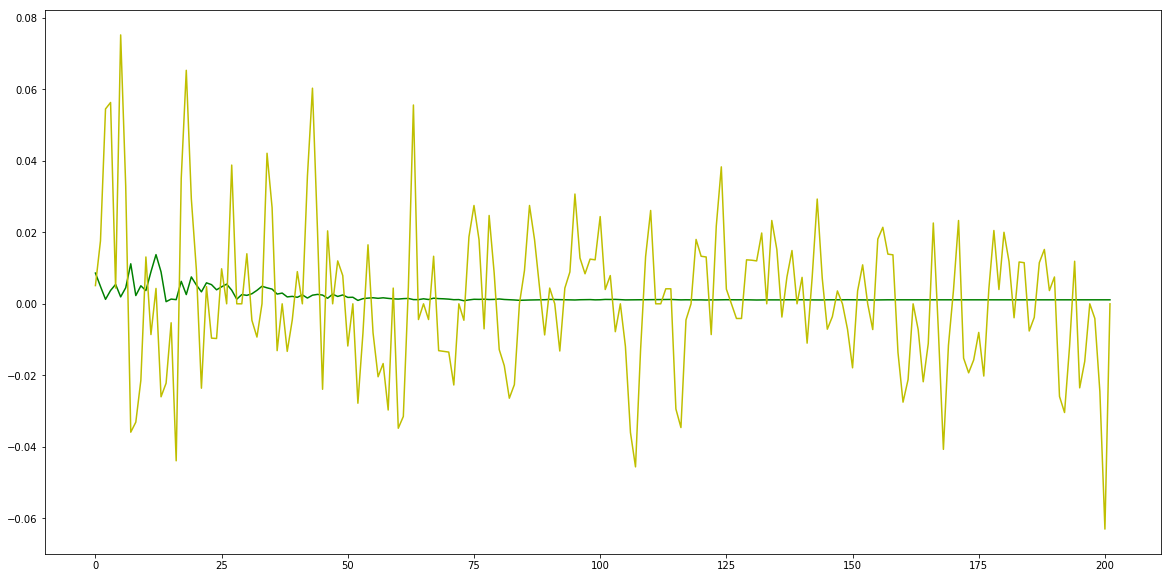

TU


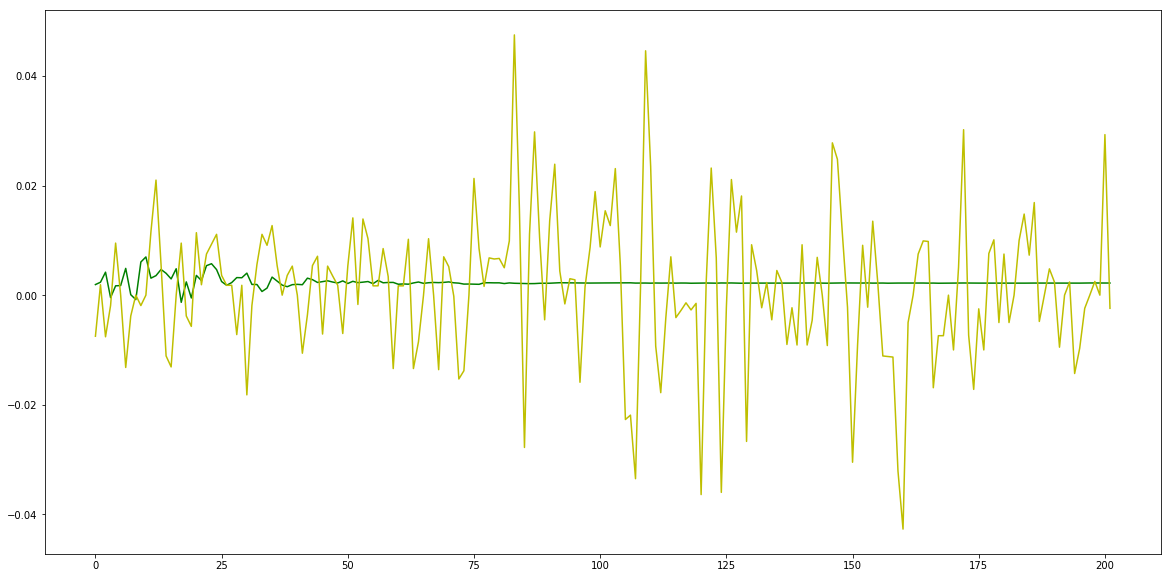

In [22]:
c = 3
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[c], i)
    data4 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data4)

In [ ]:
3(conv)*3(fc)*3(convsize)*2(fcsize)

3lstm